In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import random
import numpy as np
import os

/Users/xuqiaoying/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/xuqiaoying/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/xuqiaoying/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <572F00C8-615A-31F8-BC32-777C2024F746> /Users/xuqiaoying/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               download=False,
                               transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                               

In [572]:
def gen_sec(x: torch.Tensor, n: int) -> list:
    # x now is a tensor
    secrets = []
    batch_sz = x.shape[0]
    x_d = x.shape[1]
    len_sec = x_d // n
    for i in range(n):
        sec = torch.zeros_like(x)
        sec[:, len_sec * i: len_sec * (i + 1)] = x[:, len_sec * i: len_sec * (i + 1)]
        secrets.append(sec)
    # print(f"x_d is {x_d}")
    return secrets

x = np.arange(32)
x = torch.Tensor(np.tile(x, (4, 1)))
secrets = gen_sec(x, 8)
# print(secrets)

In [573]:
def collect_sec(secrets: list, k: int, valid=True) -> torch.Tensor:
    n = len(secrets)
    if valid:
        selected_idx = random.sample(range(n), k)
    else:
        selected_idx = random.sample(range(n), k - 1)  # any k - 1 secrets would not work
    collected = torch.zeros_like(secrets[0])
    for idx in selected_idx:
        collected += secrets[idx]
    return collected

# print(collect_sec(secrets, 6, True))
# print("=====================================")
# print(collect_sec(secrets, 6, False))
    

In [574]:
class Autoencoder(nn.Module):
    def __init__(self, n, k):
        super(Autoencoder, self).__init__()
        self.n = n
        self.k = k
        self.encoder = nn.Sequential(
            nn.Linear(784, 32),
            # nn.ReLU(),
            # nn.Linear(256, 32),
            # nn.ReLU(),
            # nn.Linear(n, k),
            # nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            # nn.Linear(32, 256),
            # nn.ReLU(),
            nn.Linear(32, 784),
            nn.Sigmoid(),
        )

    # def forward(self, x):
    #     x = self.encoder(x)  
    #     x = self.decoder(x)
    #     return x
    
    def forward(self, x):
        x = self.encoder(x)  
        secrets = gen_sec(x, self.n)  # a pool with n secrets
        
        valid_x = collect_sec(secrets, self.k, True)
        invalid_x = collect_sec(secrets, self.k, False)
        valid_y = self.decoder(valid_x)
        invalid_y = self.decoder(invalid_x)
        return valid_y, invalid_y

In [6]:

def train(n, k, epochs=50, alpha=0.5):
    model = Autoencoder(n, k).to(device)
    model_blank = Autoencoder(n, k).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(epochs):
        for img, _ in train_loader:
            img = img.view(img.size(0), -1).to(device)
            # invalid_img = torch.zeros_like(img)
            invalid_img, _ = model_blank(img)
            # print(img.shape)
            output, invalid_output = model(img)
            loss = alpha * criterion(output, img) + (1 - alpha) * criterion(invalid_output, invalid_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return losses, model
        

In [183]:
n_k = [(8, 6), (8, 7), (16, 15), (32, 31)]
losses_list = []

for n, k in n_k:
    print(f"===BEGIN TRAINING n: {n}, k: {k}===")
    losses, model = train(n, k, 30)
    model_path = f"./models_new/model_n_{n}_k_{k}.pth"
    torch.save(model.state_dict(), model_path)
    losses_list.append(losses)
# print(losses_list)
with open("losses.txt", "w") as f:
    for losses in losses_list:
        f.write(str(losses))
        f.write("\n")


===BEGIN TRAINING n: 8, k: 6===
Epoch [1/50], Loss: 0.4631
Epoch [2/50], Loss: 0.4613
Epoch [3/50], Loss: 0.4617
Epoch [4/50], Loss: 0.4623
Epoch [5/50], Loss: 0.4611
Epoch [6/50], Loss: 0.4578
Epoch [7/50], Loss: 0.4587
Epoch [8/50], Loss: 0.4564
Epoch [9/50], Loss: 0.4532
Epoch [10/50], Loss: 0.4570
Epoch [11/50], Loss: 0.4539
Epoch [12/50], Loss: 0.4526
Epoch [13/50], Loss: 0.4517
Epoch [14/50], Loss: 0.4482
Epoch [15/50], Loss: 0.4505
Epoch [16/50], Loss: 0.4522
Epoch [17/50], Loss: 0.4511
Epoch [18/50], Loss: 0.4491
Epoch [19/50], Loss: 0.4475
Epoch [20/50], Loss: 0.4510
Epoch [21/50], Loss: 0.4441
Epoch [22/50], Loss: 0.4490
Epoch [23/50], Loss: 0.4473
Epoch [24/50], Loss: 0.4527
Epoch [25/50], Loss: 0.4458
Epoch [26/50], Loss: 0.4481


KeyboardInterrupt: 

[[0.46474191546440125, 0.46209537982940674, 0.4628928005695343, 0.4609101414680481, 0.4597415030002594, 0.4602827727794647, 0.45903393626213074, 0.45333123207092285, 0.45631110668182373, 0.4522445499897003, 0.4530358910560608, 0.45560941100120544, 0.454412043094635, 0.4533976912498474, 0.4479331970214844, 0.4524283707141876, 0.45327723026275635, 0.4483068585395813, 0.45185157656669617, 0.4549599885940552], [0.462891161441803, 0.46214205026626587, 0.4625079929828644, 0.46033698320388794, 0.461467981338501, 0.45461079478263855, 0.44975271821022034, 0.4539884328842163, 0.4533826410770416, 0.4466838836669922, 0.4529809057712555, 0.44988563656806946, 0.4475467801094055, 0.44901400804519653, 0.4488735496997833, 0.44910168647766113, 0.447081059217453, 0.4515012502670288, 0.4506833553314209, 0.4474499225616455], [0.4612962305545807, 0.46047794818878174, 0.4563808739185333, 0.46375298500061035, 0.45467954874038696, 0.45115533471107483, 0.45054638385772705, 0.44681859016418457, 0.445206761360168

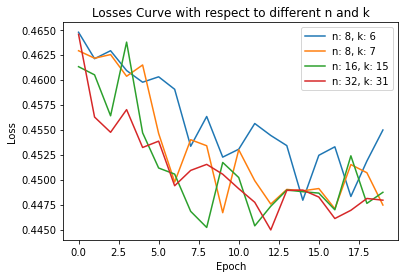

In [182]:
losses_list = []
with open("losses.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.split('[')[1].split(']')[0]
        loss_str = line.split(',')
        losses = []
        for l in loss_str:
            losses.append(float(l))
        losses_list.append(losses)  

print(losses_list)
# plot_losses(losses_list)



In [576]:
def plot_losses(losses_list):
    for i, losses in enumerate(losses_list):
        # plt.plot(losses, label=f"n: {n_k[i][0]}, k: {n_k[i][1]}")
        plt.plot(losses, label=f"alpha: {0.1 * (i + 2):.1f}")
    plt.legend()
    # plt.title("Losses Curve with respect to different n and k")
    plt.title("Losses Curve with respect to different alphas")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# plot_losses(losses_list)

In [577]:
def plot_samples(model, idx_list=[]):
    fig = plt.figure()
    plt.figure(figsize=(15, 10))

    num_samples = 5
    for i in range(num_samples):
        if len(idx_list):
            idx = idx_list[i]
        else:
            idx = random.randint(0, len(test_dataset) - 1)
            print(f"idx: {idx}")
        img = test_dataset[idx][0][0]
        with torch.no_grad():
            reconstructed, invalid_recons = model(img.view(-1, 784).to(device))
        
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Origin")

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed.view(28, 28).to('cpu'), cmap='gray')
        plt.title(f"Valid")

        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(invalid_recons.view(28, 28).to('cpu'), cmap='gray')
        plt.title(f"Invalid")


In [461]:
alphas = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
loss_alpha = []
model_alpha = []
for alpha in alphas:
    loss, model = train(8, 6, 30, alpha=alpha)
    loss_alpha.append(loss)
    model_alpha.append(model)


Epoch [1/30], Loss: 0.2881
Epoch [2/30], Loss: 0.3404
Epoch [3/30], Loss: 0.3667
Epoch [4/30], Loss: 0.2429
Epoch [5/30], Loss: 0.2918
Epoch [6/30], Loss: 0.2877
Epoch [7/30], Loss: 0.2882
Epoch [8/30], Loss: 0.3160
Epoch [9/30], Loss: 0.2743
Epoch [10/30], Loss: 0.2357
Epoch [11/30], Loss: 0.2428
Epoch [12/30], Loss: 0.2667
Epoch [13/30], Loss: 0.2495
Epoch [14/30], Loss: 0.2910
Epoch [15/30], Loss: 0.2605
Epoch [16/30], Loss: 0.2566
Epoch [17/30], Loss: 0.2349
Epoch [18/30], Loss: 0.2727
Epoch [19/30], Loss: 0.2602
Epoch [20/30], Loss: 0.2503
Epoch [21/30], Loss: 0.2982
Epoch [22/30], Loss: 0.2430
Epoch [23/30], Loss: 0.2154
Epoch [24/30], Loss: 0.2340
Epoch [25/30], Loss: 0.2447
Epoch [26/30], Loss: 0.2528
Epoch [27/30], Loss: 0.2355
Epoch [28/30], Loss: 0.2306
Epoch [29/30], Loss: 0.2286
Epoch [30/30], Loss: 0.2167
Epoch [1/30], Loss: 0.4497
Epoch [2/30], Loss: 0.4300
Epoch [3/30], Loss: 0.4185
Epoch [4/30], Loss: 0.4028
Epoch [5/30], Loss: 0.3647
Epoch [6/30], Loss: 0.3560
Epoch [

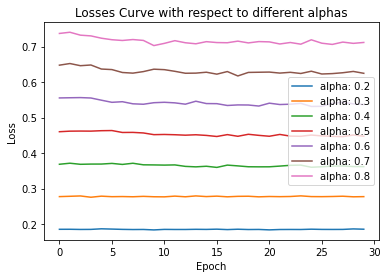

In [350]:
plot_losses(loss_alpha)

In [544]:
# model_dummy = Autoencoder(8, 7).to(device)
model_8_7 = train(8, 7, 5, alpha=0.4)


Epoch [1/5], Loss: 0.4833
Epoch [2/5], Loss: 0.4400
Epoch [3/5], Loss: 0.4664
Epoch [4/5], Loss: 0.4630
Epoch [5/5], Loss: 0.4420


In [540]:
model_8_6 = train(8, 6, 5, alpha=0.4)
model_16_15 = train(8, 6, 5, alpha=0.4)
model_32_31 = train(8, 6, 5, alpha=0.4)


Epoch [1/5], Loss: 0.4926
Epoch [2/5], Loss: 0.4537
Epoch [3/5], Loss: 0.4415
Epoch [4/5], Loss: 0.4456
Epoch [5/5], Loss: 0.4597
Epoch [1/5], Loss: 0.4906
Epoch [2/5], Loss: 0.4830
Epoch [3/5], Loss: 0.4362
Epoch [4/5], Loss: 0.4574
Epoch [5/5], Loss: 0.4561
Epoch [1/5], Loss: 0.4915
Epoch [2/5], Loss: 0.4803
Epoch [3/5], Loss: 0.4545
Epoch [4/5], Loss: 0.4431
Epoch [5/5], Loss: 0.4528


In [569]:
def plot_different_models(models):
    # generate a random image
    idx = random.randint(0, len(test_dataset) - 1)
    img = test_dataset[idx][0][0]

    fig, axs = plt.subplots(3, len(models), figsize=(12, 9))
    fig.suptitle("Comparation of Different alpha")
    original = img
    
    for i in range(len(models)):
        # n, k = n_k[i]
        model = models[i]
        alpha = i * 0.1 + 0.3
        with torch.no_grad():
            valid, _ = model(img.view(-1, 784).to(device))
            
        # Original image
        axs[0, i].imshow(original.numpy().squeeze())
        # axs[0, i].set_title(f'Model {n}_{k} Original')
        axs[0, i].set_title(f'Alpha = {alpha: .1f}')
        axs[0, i].axis('off')

        # Valid image
        axs[1, i].imshow(valid.view(28, 28).to(device))
        # axs[1, i].set_title(f'Model {n}_{k} Valid')
        axs[0, i].set_title(f'Alpha = {alpha: .1f}')
        axs[1, i].axis('off')

        # Invalid image
        axs[2, i].imshow(invalid.view(28, 28).to(device))
        # axs[2, i].set_title(f'Model {n}_{k} Invalid')
        axs[0, i].set_title(f'Alpha = {alpha: .1f}')
        axs[2, i].axis('off')

    # fig.suptitle('Overall Figure Title')
    plt.tight_layout()
    plt.show()


Epoch [1/5], Loss: 0.3860
Epoch [2/5], Loss: 0.4027
Epoch [3/5], Loss: 0.4414
Epoch [4/5], Loss: 0.4173
Epoch [5/5], Loss: 0.3531
Epoch [1/5], Loss: 0.4796
Epoch [2/5], Loss: 0.4682
Epoch [3/5], Loss: 0.4493
Epoch [4/5], Loss: 0.4491
Epoch [5/5], Loss: 0.4537
Epoch [1/5], Loss: 0.5580
Epoch [2/5], Loss: 0.5465
Epoch [3/5], Loss: 0.5407
Epoch [4/5], Loss: 0.5405
Epoch [5/5], Loss: 0.5341
Epoch [1/5], Loss: 0.6319
Epoch [2/5], Loss: 0.6222
Epoch [3/5], Loss: 0.6177
Epoch [4/5], Loss: 0.6140
Epoch [5/5], Loss: 0.6144
Epoch [1/5], Loss: 0.7053
Epoch [2/5], Loss: 0.6980
Epoch [3/5], Loss: 0.6898
Epoch [4/5], Loss: 0.6853
Epoch [5/5], Loss: 0.6851


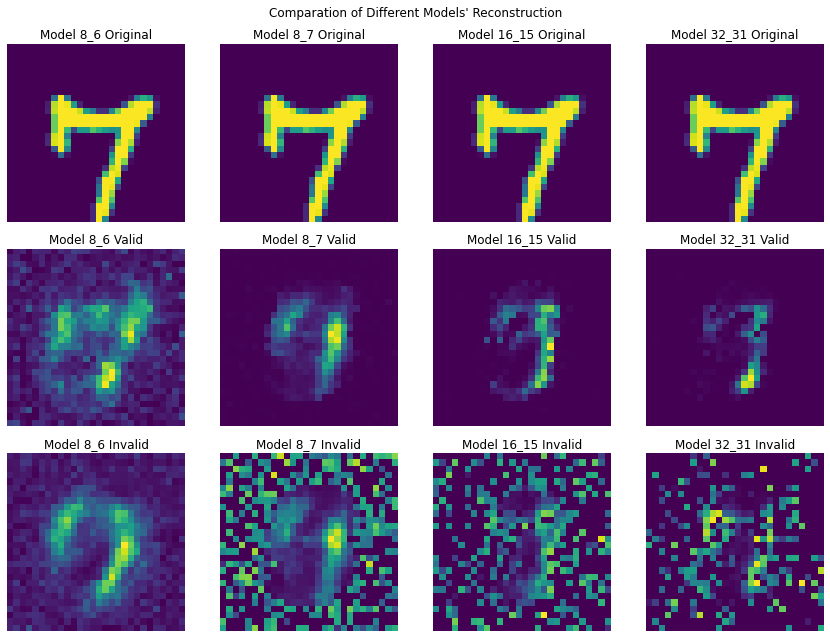

In [564]:
model_alphas = []
for alpha in [0.3, 0.4, 0.5, 0.6, 0.7]:
    _, model = train(8, 6, 5, alpha)
    model_alphas.append(model)

plot_different_models(model_alphas)

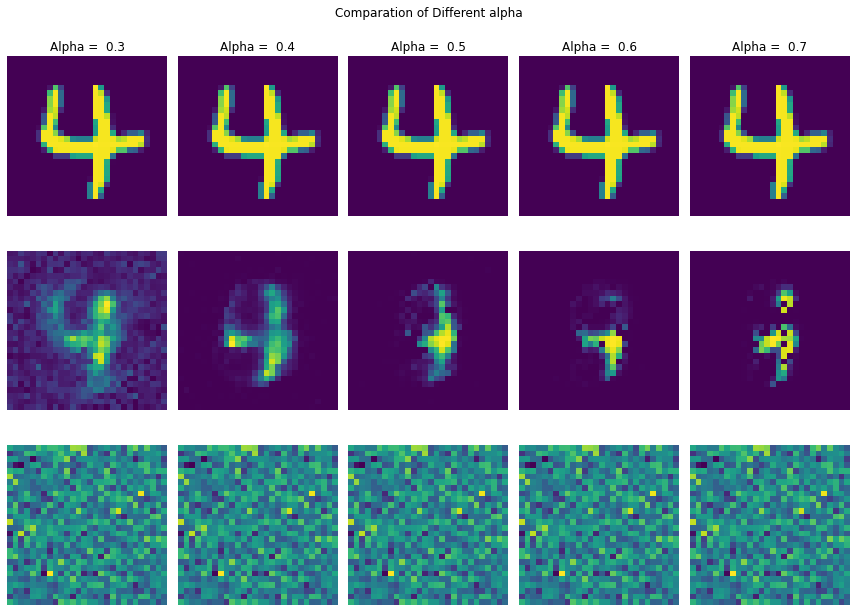

In [570]:
plot_different_models(model_alphas)